In [1]:
##  explore the QCEW data

##  Eryk Wdowiak
##  29 July 2019

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

#import scipy.stats as st
import math

import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
qcew = pd.read_csv('qcew2019.csv')
qcew = qcew[qcew.columns[1:]]
#qcew.head()

In [4]:
##  let's rename the columns, so that we can interpret them
qcew = qcew.rename(columns = {'pct_sp1011': 'pct_naturalres',
                              'pct_sp1012': 'pct_construct',
                              'pct_sp1013': 'pct_manufact',
                              'pct_sp1021': 'pct_trade_trans',
                              'pct_sp1022': 'pct_information',
                              'pct_sp1023': 'pct_financial',
                              'pct_sp1024': 'pct_business_srvcs',
                              'pct_sp1025': 'pct_edu_health',
                              'pct_sp1026': 'pct_leisure_hosp',
                              'pct_sp1027': 'pct_other_srvcs',
                              'pct_sp1028': 'pct_public_admin',
                              'pct_sp1029': 'pct_unclassified'})


##  and let's aggregate goods producing employment
qcew['pct_goods'] = qcew['pct_naturalres'] + qcew['pct_construct'] + qcew['pct_manufact']

##  remove bad observations (small counties)
qcew = qcew[qcew['nn_pay'] >= 100]
qcew = qcew[qcew['cv_pay'] >= 0.10]
#qcew = qcew[qcew['mn_pay'] != 0]

##  and take logs
qcew['ln_mnpay'] = np.log(qcew['mn_pay'])
qcew['ln_cvpay'] = np.log(qcew['cv_pay'])

In [5]:
##  and let's aggregate goods producing employment
##  (other sectors are service sectors)
qcew['pct_goods'] = qcew['pct_naturalres'] + qcew['pct_construct'] + qcew['pct_manufact']

##  let's create a variable to measure dispersion across industries
##  if all in one sector, then zero (not disperse):  1 - 1^2 = 0
qcew['dispersion'] = 1 - (((qcew['pct_naturalres'])**2) + 
                          ((qcew['pct_construct'])**2) + 
                          ((qcew['pct_manufact'])**2) + 
                          ((qcew['pct_trade_trans'])**2) + 
                          ((qcew['pct_information'])**2) + 
                          ((qcew['pct_financial'])**2) + 
                          ((qcew['pct_business_srvcs'])**2) + 
                          ((qcew['pct_edu_health'])**2) + 
                          ((qcew['pct_leisure_hosp'])**2) + 
                          ((qcew['pct_other_srvcs'])**2) + 
                          ((qcew['pct_public_admin'])**2) + 
                          ((qcew['pct_unclassified'])**2))

##  given the nature of this dataset ... remove low dispersion
qcew = qcew[qcew['dispersion'] >= 0.50]

In [6]:
qcew.head()

,fips_code,state_code,mn_pay,sd_pay,cv_pay,nn_pay,pct_naturalres,pct_construct,pct_manufact,pct_trade_trans,...,pct_business_srvcs,pct_edu_health,pct_leisure_hosp,pct_other_srvcs,pct_public_admin,pct_unclassified,pct_goods,ln_mnpay,ln_cvpay,dispersion
0,1001,1,29632.055008,20429.677384,0.689445,2945.0,0.016859,0.047954,0.149199,0.225532,...,0.057132,0.215978,0.148450,0.022010,0.075021,0.0,0.214011,10.296612,-0.371868,0.844704
1,1003,1,35913.813703,19153.479048,0.533318,50763.0,0.010417,0.056883,0.056974,0.244958,...,0.080613,0.203905,0.208268,0.026875,0.053214,0.0,0.124274,10.488877,-0.628638,0.835631
2,1005,1,28959.026455,17035.771078,0.588272,1890.0,0.038785,0.017787,0.303113,0.185400,...,0.041749,0.163538,0.093256,0.018281,0.109066,0.0,0.359684,10.273637,-0.530567,0.821773
3,1007,1,31619.975917,17548.469786,0.554980,872.0,0.017798,0.167519,0.137709,0.209789,...,0.026029,0.281646,0.044494,0.000000,0.093215,0.0,0.323026,10.361544,-0.588822,0.817499
4,1009,1,33609.382488,16074.723801,0.478281,3689.0,0.010205,0.067097,0.158710,0.201877,...,0.050792,0.257947,0.105220,0.037302,0.072727,0.0,0.236012,10.422561,-0.737557,0.841589


In [7]:
##   Eunjoo's helper function to make dummies
def dummies(x, prefix):
    """
    Helper function to make dummies
    Input: series or array, prefix string
    Output: dummy dataframe
    """
    dummy = pd.get_dummies(x, prefix = prefix) ## drop_first = True)
    return dummy

In [8]:
##  turn states into dummy variables
st_df = dummies(qcew['state_code'],'st')

st_df = st_df.rename(columns = {
    'st_1':'Alabama','st_2':'Alaska','st_4':'Arizona','st_5':'Arkansas',
    'st_6':'California','st_8':'Colorado','st_9':'Connecticut',
    'st_10':'Delaware','st_11':'DistColumbia',
    'st_12':'Florida','st_13':'Georgia','st_15':'Hawaii','st_16':'Idaho',
    'st_17':'Illinois','st_18':'Indiana','st_19':'Iowa','st_20':'Kansas',
    'st_21':'Kentucky','st_22':'Louisiana','st_23':'Maine','st_24':'Maryland',
    'st_25':'Massachusetts','st_26':'Michigan','st_27':'Minnesota','st_28':'Mississippi',
    'st_29':'Missouri','st_30':'Montana','st_31':'Nebraska','st_32':'Nevada',
    'st_33':'NewHampshire','st_34':'NewJersey','st_35':'NewMexico','st_36':'NewYork',
    'st_37':'NorthCarolina','st_38':'NorthDakota','st_39':'Ohio','st_40':'Oklahoma',
    'st_41':'Oregon','st_42':'Pennsylvania','st_44':'RhodeIsland','st_45':'SouthCarolina',
    'st_46':'SouthDakota','st_47':'Tennessee','st_48':'Texas','st_49':'Utah',
    'st_50':'Vermont','st_51':'Virginia','st_53':'Washington','st_54':'WestVirginia',
    'st_55':'Wisconsin','st_56':'Wyoming','st_60':'AmericanSamoa','st_66':'Guam',
    'st_69':'NorthMarianaIsl','st_72':'PuertoRico','st_78':'VirginIslands'})

##  add them to data frame
qcew = qcew.join(st_df)

##  get a list of dummies
st_dummies = list(st_df.columns)

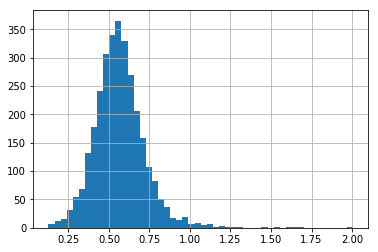

In [9]:
qcew['cv_pay'].hist(bins=50);

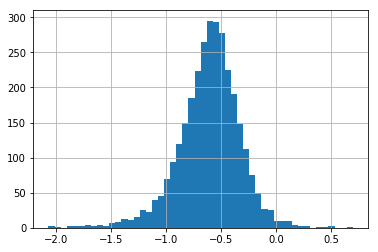

In [10]:
qcew['ln_cvpay'].hist(bins=50);

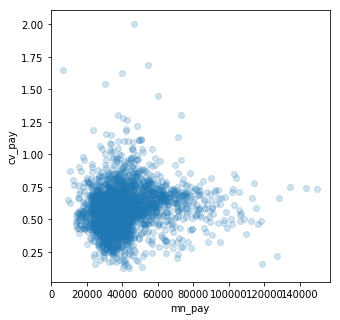

In [11]:
fig, axes = plt.subplots(figsize = (5, 5))
#axes.scatter(qcew['ln_mnpay'], qcew['ln_cvpay'], alpha = 0.2)
#axes.set_xlabel('ln_mnpay')
#axes.set_ylabel('ln_cvpay');
axes.scatter(qcew['mn_pay'], qcew['cv_pay'], alpha = 0.2)
axes.set_xlabel('mn_pay')
axes.set_ylabel('cv_pay');

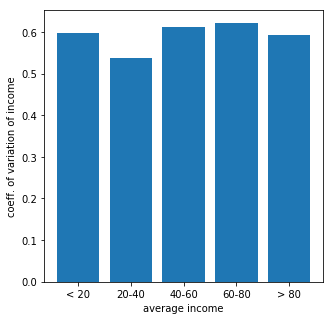

In [12]:
qcew['mn_pay_buckets'] = pd.cut(qcew['mn_pay'], [0,20000,40000,60000,80000,500000],
                                labels=['< 20','20-40','40-60','60-80','> 80'])

mnpay_cvpay = qcew.groupby('mn_pay_buckets')['cv_pay'].mean()

fig, axes = plt.subplots(figsize = (5, 5))
axes.bar(mnpay_cvpay.index, mnpay_cvpay.values);
axes.set_xlabel('average income')
axes.set_ylabel('coeff. of variation of income');

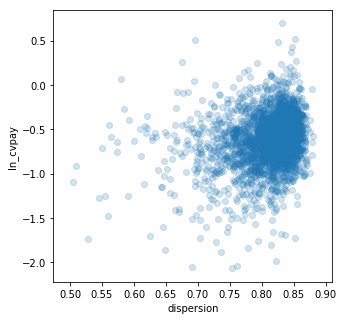

In [13]:
fig, axes = plt.subplots(figsize = (5, 5))
axes.scatter(qcew['dispersion'], qcew['ln_cvpay'], alpha = 0.2)
axes.set_xlabel('dispersion')
axes.set_ylabel('ln_cvpay');

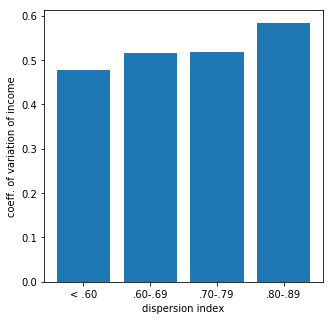

In [14]:
qcew['dispers_buckets'] = pd.cut(qcew['dispersion'], [0,0.60,0.70,0.80,0.90,2.00],
                                 labels=['< .60','.60-.69','.70-.79','.80-.89','.90-1.00'])

dispers_cvpay = qcew.groupby('dispers_buckets')['cv_pay'].mean()

fig, axes = plt.subplots(figsize = (5, 5))
axes.bar(dispers_cvpay.index, dispers_cvpay.values);
axes.set_xlabel('dispersion index')
axes.set_ylabel('coeff. of variation of income');

In [15]:
##  mass_bucketing and plotting function
def mass_bucketing(df, yy = 'cv_pay'):
    
    ##  bucket sizes and label names
    buckets = [0,0.20,0.40,0.60,0.80,1.00]
    bkt_labels = ['< .20','.20-.39','.40-.59','.60-.79','.80-1.00']
    
    ##  how many rows and columns of plots?
    a = len(df.columns) - 1
    ncols = math.ceil(a**.5)
    nrows = math.ceil(a/ncols)
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (12, 12))

    axes = axes.ravel()
    
    for i in range(len(df.columns) -1):
        col_name = df.columns[i]
        bkt_name = col_name + '_bkt'
        bkts = df[[yy,col_name]]
        
        bkts[bkt_name] = pd.cut(bkts[col_name], buckets, labels=bkt_labels)
        
        bkt_table = bkts.groupby(bkt_name)[yy].mean()
        
        axes[i].bar(bkt_table.index, bkt_table.values);
        #axes[i].set_xlabel(col_name)
        axes[i].set_title(col_name)
        #axes[i].set_ylabel('cv income');

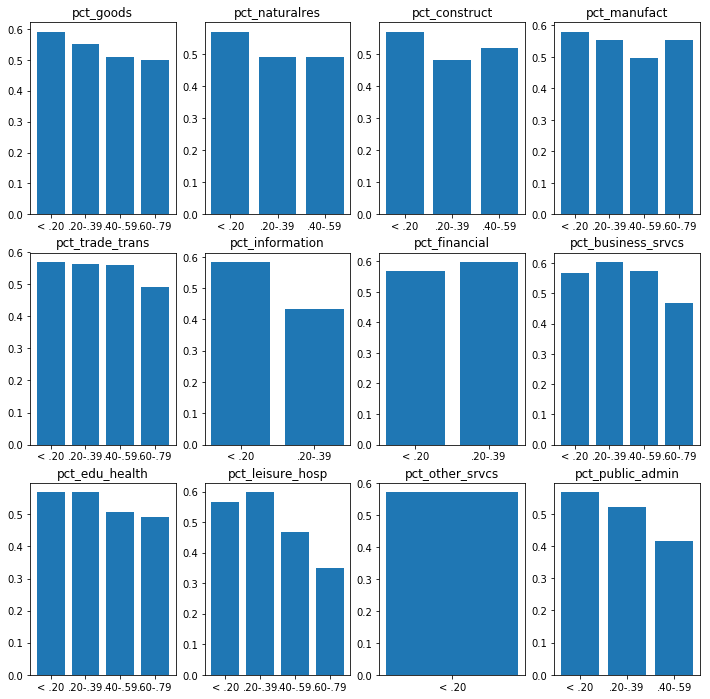

In [16]:
cols_int = ['pct_goods',
            'pct_naturalres', 'pct_construct', 'pct_manufact',
            'pct_trade_trans','pct_information', 'pct_financial', 
            'pct_business_srvcs','pct_edu_health', 'pct_leisure_hosp', 
            'pct_other_srvcs','pct_public_admin']#, 'pct_unclassified']

mass_bucketing(qcew[cols_int + ['cv_pay']])

In [17]:
# Eunjoo's mass_scatter function
def mass_scatter(df, y = 'ln_cvpay'):
    a = len(df.columns)
    ncols = math.ceil(a**.5)
    nrows = math.ceil(a/ncols)
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (12, 15))

    axes = axes.ravel()

    for i in range(len(df.columns)):
        axes[i].scatter(df.iloc[:, i], df[y], alpha = 0.2)
        axes[i].set_title(df.columns[i])
        axes[i].get_yaxis().set_ticks([])

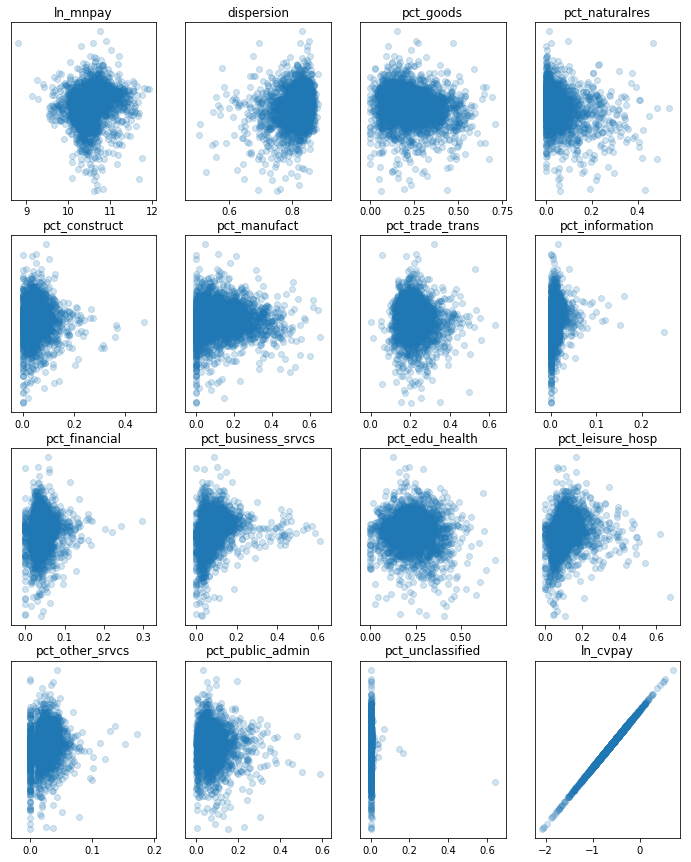

In [18]:
cols_int = ['ln_mnpay', #'ln_cvpay',
            'dispersion',
            'pct_goods',
            'pct_naturalres', 'pct_construct', 'pct_manufact',
            'pct_trade_trans','pct_information', 'pct_financial', 
            'pct_business_srvcs','pct_edu_health', 'pct_leisure_hosp', 
            'pct_other_srvcs','pct_public_admin', 'pct_unclassified']

mass_scatter(qcew[cols_int + ['ln_cvpay']])

In [19]:
cols_int = ['ln_cvpay','ln_mnpay',
            'dispersion',
            'pct_goods',
            'pct_naturalres', 'pct_construct', 'pct_manufact',
            'pct_trade_trans','pct_information', 'pct_financial', 
            'pct_business_srvcs','pct_edu_health', 'pct_leisure_hosp', 
            'pct_other_srvcs','pct_public_admin', 'pct_unclassified']
qcew[cols_int].corr()[0:2].transpose()

,ln_cvpay,ln_mnpay
ln_cvpay,1.000000,0.139463
ln_mnpay,0.139463,1.000000
dispersion,0.249410,0.103548
pct_goods,-0.167266,-0.201473
pct_naturalres,-0.267198,-0.035261
pct_construct,0.004824,0.118977
pct_manufact,-0.018027,-0.234140
pct_trade_trans,-0.049362,-0.132957
pct_information,0.157796,0.378038
pct_financial,0.083539,0.256548


In [20]:
##  list of exogenous variables for regression model
exog = ['dispersion']
exog = exog + ['ln_mnpay']

In [21]:
##  run weighted least squares regression
m01a_fmla = 'ln_cvpay~'
m01a_fmla = m01a_fmla + '+'.join(exog)

m01a_wls = smf.wls(m01a_fmla,data=qcew, weights=qcew['nn_pay']).fit() 
m01a_wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:               ln_cvpay   R-squared:                       0.139
Model:                            WLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     248.5
Date:                Thu, 30 Jul 2020   Prob (F-statistic):          9.20e-101
Time:                        14:58:19   Log-Likelihood:                -1830.2
No. Observations:                3082   AIC:                             3666.
Df Residuals:                    3079   BIC:                             3685.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.7351      0.104    -26.312      0.000      -2.939      -2.531
dispersion     0.9354      0.075     12.462      0.000       0.788       1.083
ln_mnpay       0.1383      0.008     17.994      0.000       0.123       0.153
==============================================================================
Omnibus:                     1782.585   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           198229.214
Skew:                           1.802   Prob(JB):                         0.00
Kurtosis:                      42.124   Cond. No.                         505.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
##  list of exogenous variables for regression model
exog = ['dispersion']
exog = exog + ['ln_mnpay']
exog = exog + ['pct_goods']

In [23]:
##  run weighted least squares regression
m01b_fmla = 'ln_cvpay~'
m01b_fmla = m01b_fmla + '+'.join(exog)

m01b_wls = smf.wls(m01b_fmla,data=qcew, weights=qcew['nn_pay']).fit() 
m01b_wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:               ln_cvpay   R-squared:                       0.153
Model:                            WLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     185.1
Date:                Thu, 30 Jul 2020   Prob (F-statistic):          2.29e-110
Time:                        14:58:19   Log-Likelihood:                -1805.1
No. Observations:                3082   AIC:                             3618.
Df Residuals:                    3078   BIC:                             3642.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4092      0.113    -21.348      0.000      -2.631      -2.188
dispersion     1.0510      0.076     13.789      0.000       0.902       1.200
ln_mnpay       0.1043      0.009     11.571      0.000       0.087       0.122
pct_goods     -0.3147      0.044     -7.106      0.000      -0.402      -0.228
==============================================================================
Omnibus:                     1727.107   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           222701.983
Skew:                           1.667   Prob(JB):                         0.00
Kurtosis:                      44.510   Cond. No.                         530.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
hnull = '(pct_goods = 0)'
m01b_ftest = m01b_wls.f_test(hnull)

fstat = list(m01b_ftest.fvalue[0])[0]
pval = 1.0*m01b_ftest.pvalue
print()
print('H0:  ' + hnull)
print()
print('F stat:  ' + str(round(fstat,4)))
print('pvalue:   ' + str(round(pval,4)))
print()


H0:  (pct_goods = 0)

F stat:  50.4907
pvalue:   0.0



In [25]:
##  list of exogenous variables for regression model
exog = ['dispersion']
exog = exog + ['ln_mnpay']
exog = exog + ['pct_naturalres']
exog = exog + ['pct_construct']
exog = exog + ['pct_manufact']
exog = exog + ['pct_trade_trans']
exog = exog + ['pct_information']
exog = exog + ['pct_financial']
exog = exog + ['pct_business_srvcs']
exog = exog + ['pct_edu_health']
exog = exog + ['pct_leisure_hosp']
#exog = exog + ['pct_other_srvcs']
exog = exog + ['pct_public_admin']
#exog = exog + ['pct_unclassified']

In [26]:
##  run weighted least squares regression
m02_fmla = 'ln_cvpay~'
m02_fmla = m02_fmla + '+'.join(exog)

m02_wls = smf.wls(m02_fmla,data=qcew, weights=qcew['nn_pay']).fit() 
m02_wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:               ln_cvpay   R-squared:                       0.271
Model:                            WLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     95.00
Date:                Thu, 30 Jul 2020   Prob (F-statistic):          3.32e-200
Time:                        14:58:20   Log-Likelihood:                -1574.0
No. Observations:                3082   AIC:                             3174.
Df Residuals:                    3069   BIC:                             3252.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -4.7248      0.283    -16.686      0.000      -5.280      -4.170
dispersion             1.0987      0.090     12.190      0.000       0.922       1.275
ln_mnpay               0.2083      0.013     16.368      0.000       0.183       0.233
pct_naturalres         0.4812      0.226      2.125      0.034       0.037       0.925
pct_construct          0.7578      0.268      2.823      0.005       0.232       1.284
pct_manufact           0.7634      0.226      3.378      0.001       0.320       1.207
pct_trade_trans        1.1889      0.229      5.184      0.000       0.739       1.639
pct_information        0.4688      0.285      1.647      0.100      -0.089       1.027
pct_financial          0.4831      0.252      1.919      0.055      -0.011       0.977
pct_business_srvcs     0.8967      0.225      3.984      0.000       0.455       1.338
pct_edu_health         1.6333      0.229      7.143      0.000       1.185       2.082
pct_leisure_hosp       1.4171      0.232      6.102      0.000       0.962       1.872
pct_public_admin       0.5096      0.252      2.019      0.044       0.015       1.005
==============================================================================
Omnibus:                     1816.094   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           131743.989
Skew:                           1.983   Prob(JB):                         0.00
Kurtosis:                      34.783   Cond. No.                     3.61e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
##  run weighted least squares regression with state effects
holdout = ['California'] 
state_dum_list = [val for val in st_dummies if val not in holdout]
exog_state = exog + state_dum_list

m03_fmla = 'ln_cvpay~'
m03_fmla = m03_fmla + '+'.join(exog_state)

m03_wls = smf.wls(m03_fmla,data=qcew, weights=qcew['nn_pay']).fit() 
m03_wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:               ln_cvpay   R-squared:                       0.364
Model:                            WLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     26.99
Date:                Thu, 30 Jul 2020   Prob (F-statistic):          4.17e-246
Time:                        14:58:20   Log-Likelihood:                -1363.2
No. Observations:                3082   AIC:                             2856.
Df Residuals:                    3017   BIC:                             3249.
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -3.7088      0.339    -10.934      0.000      -4.374      -3.044
dispersion             0.9088      0.093      9.741      0.000       0.726       1.092
ln_mnpay               0.2463      0.015     16.008      0.000       0.216       0.276
pct_naturalres        -0.7334      0.278     -2.638      0.008      -1.278      -0.188
pct_construct         -0.5283      0.329     -1.606      0.108      -1.173       0.117
pct_manufact          -0.4852      0.273     -1.779      0.075      -1.020       0.050
pct_trade_trans       -0.2237      0.281     -0.797      0.426      -0.774       0.327
pct_information       -1.0455      0.342     -3.059      0.002      -1.716      -0.375
pct_financial         -1.0207      0.302     -3.379      0.001      -1.613      -0.429
pct_business_srvcs    -0.4084      0.273     -1.494      0.135      -0.944       0.128
pct_edu_health         0.3480      0.279      1.248      0.212      -0.199       0.895
pct_leisure_hosp       0.1508      0.284      0.531      0.595      -0.406       0.707
pct_public_admin      -0.5577      0.287     -1.942      0.052      -1.121       0.005
Alabama                0.0143      0.023      0.621      0.535      -0.031       0.060
Alaska                -0.0349      0.056     -0.623      0.533      -0.145       0.075
Arizona               -0.0109      0.017     -0.641      0.521      -0.044       0.022
Arkansas               0.0613      0.031      2.002      0.045       0.001       0.121
Colorado               0.0217      0.018      1.195      0.232      -0.014       0.057
Connecticut            0.0334      0.022      1.525      0.127      -0.010       0.076
Delaware               0.0231      0.044      0.525      0.600      -0.063       0.109
DistColumbia          -0.3979      0.038    -10.482      0.000      -0.472      -0.324
Florida                0.0440      0.013      3.437      0.001       0.019       0.069
Georgia               -0.0494      0.016     -3.065      0.002      -0.081      -0.018
Hawaii                -0.1930      0.033     -5.813      0.000      -0.258      -0.128
Idaho                  0.0565      0.036      1.556      0.120      -0.015       0.128
Illinois               0.0438      0.014      3.245      0.001       0.017       0.070
Indiana                0.0302      0.020      1.538      0.124      -0.008       0.069
Iowa                  -0.0450      0.028     -1.599      0.110      -0.100       0.010
Kansas                -0.0782      0.027     -2.853      0.004      -0.132      -0.024
Kentucky               0.0251      0.026      0.972      0.331      -0.026       0.076
Louisiana              0.0727      0.023      3.200      0.001       0.028       0.117
Maine                 -0.0580      0.038     -1.515      0.130      -0.133       0.017
Maryland              -0.0784      0.0

In [28]:
hnull = '(Alabama = 0), (Alaska = 0), (Arizona = 0), (Arkansas = 0), '
#hnull = hnull + '(California = 0), '
hnull = hnull + '(Colorado = 0), (Connecticut = 0), '
hnull = hnull + '(Delaware = 0), (Florida = 0), (Georgia = 0), (Hawaii = 0), '
hnull = hnull + '(Idaho = 0), (Illinois = 0), (Indiana = 0), (Iowa = 0), '
hnull = hnull + '(Kansas = 0), (Kentucky = 0), (Louisiana = 0), (Maine = 0), '
hnull = hnull + '(Maryland = 0), (Massachusetts = 0), (Michigan = 0), (Minnesota = 0), '
hnull = hnull + '(Mississippi = 0), (Missouri = 0), (Montana = 0), (Nebraska = 0), '
hnull = hnull + '(Nevada = 0), (NewHampshire = 0), (NewJersey = 0), (NewMexico = 0), '
hnull = hnull + '(NewYork = 0), (NorthCarolina = 0), (NorthDakota = 0), (Ohio = 0), '
hnull = hnull + '(Oklahoma = 0), (Oregon = 0), (Pennsylvania = 0), (RhodeIsland = 0), '
hnull = hnull + '(SouthCarolina = 0), (SouthDakota = 0), (Tennessee = 0), (Texas = 0), '
hnull = hnull + '(Utah = 0), (Vermont = 0), (Virginia = 0), (Washington = 0), '
hnull = hnull + '(WestVirginia = 0), (Wisconsin = 0), (Wyoming = 0), '
#hnull = hnull + '(AmericanSamoa = 0), (Guam = 0), (NorthMarianaIsl = 0), '
hnull = hnull + '(PuertoRico = 0), (VirginIslands = 0)'

m03_ftest = m03_wls.f_test(hnull)

fstat = list(m03_ftest.fvalue[0])[0]
pval = 1.0*m03_ftest.pvalue
print()
print('H0:  ' + hnull)
print()
print('F stat:  ' + str(round(fstat,4)))
print('pvalue:  ' + str(round(pval,4)))
print()


H0:  (Alabama = 0), (Alaska = 0), (Arizona = 0), (Arkansas = 0), (Colorado = 0), (Connecticut = 0), (Delaware = 0), (Florida = 0), (Georgia = 0), (Hawaii = 0), (Idaho = 0), (Illinois = 0), (Indiana = 0), (Iowa = 0), (Kansas = 0), (Kentucky = 0), (Louisiana = 0), (Maine = 0), (Maryland = 0), (Massachusetts = 0), (Michigan = 0), (Minnesota = 0), (Mississippi = 0), (Missouri = 0), (Montana = 0), (Nebraska = 0), (Nevada = 0), (NewHampshire = 0), (NewJersey = 0), (NewMexico = 0), (NewYork = 0), (NorthCarolina = 0), (NorthDakota = 0), (Ohio = 0), (Oklahoma = 0), (Oregon = 0), (Pennsylvania = 0), (RhodeIsland = 0), (SouthCarolina = 0), (SouthDakota = 0), (Tennessee = 0), (Texas = 0), (Utah = 0), (Vermont = 0), (Virginia = 0), (Washington = 0), (WestVirginia = 0), (Wisconsin = 0), (Wyoming = 0), (PuertoRico = 0), (VirginIslands = 0)

F stat:  6.4982
pvalue:  0.0



In [29]:
hnull = '(pct_naturalres = 0), (pct_construct = 0), (pct_manufact = 0), '
hnull = hnull + '(pct_trade_trans = 0), (pct_information = 0), (pct_financial = 0), '
hnull = hnull + '(pct_business_srvcs = 0), (pct_edu_health = 0), '
hnull = hnull + '(pct_leisure_hosp = 0), (pct_public_admin = 0)'

m03_ftest = m03_wls.f_test(hnull)

fstat = list(m03_ftest.fvalue[0])[0]
pval = 1.0*m03_ftest.pvalue
print()
print('H0:  ' + hnull)
print()
print('F stat:  ' + str(round(fstat,4)))
print('pvalue:   ' + str(round(pval,4)))
print()


H0:  (pct_naturalres = 0), (pct_construct = 0), (pct_manufact = 0), (pct_trade_trans = 0), (pct_information = 0), (pct_financial = 0), (pct_business_srvcs = 0), (pct_edu_health = 0), (pct_leisure_hosp = 0), (pct_public_admin = 0)

F stat:  51.8304
pvalue:   0.0



In [30]:
##  list of exogenous variables for regression model
exog = ['dispersion']
exog = exog + ['ln_mnpay']
# exog = exog + ['pct_naturalres']
# exog = exog + ['pct_construct']
# exog = exog + ['pct_manufact']
# exog = exog + ['pct_trade_trans']
# exog = exog + ['pct_information']
# exog = exog + ['pct_financial']
# exog = exog + ['pct_business_srvcs']
# exog = exog + ['pct_edu_health']
# exog = exog + ['pct_leisure_hosp']
# #exog = exog + ['pct_other_srvcs']
# exog = exog + ['pct_public_admin']
# #exog = exog + ['pct_unclassified']

In [31]:
##  run weighted least squares regression with state effects
holdout = ['California'] 
state_dum_list = [val for val in st_dummies if val not in holdout]
exog_state = exog + state_dum_list

m04_fmla = 'ln_cvpay~'
m04_fmla = m04_fmla + '+'.join(exog_state)

m04_wls = smf.wls(m04_fmla,data=qcew, weights=qcew['nn_pay']).fit() 
m04_wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:               ln_cvpay   R-squared:                       0.255
Model:                            WLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     19.17
Date:                Thu, 30 Jul 2020   Prob (F-statistic):          2.68e-153
Time:                        14:58:21   Log-Likelihood:                -1607.5
No. Observations:                3082   AIC:                             3325.
Df Residuals:                    3027   BIC:                             3657.
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.6032      0.114    -22.899      0.000      -2.826      -2.380
dispersion        0.9611      0.073     13.111      0.000       0.817       1.105
ln_mnpay          0.1275      0.009     14.734      0.000       0.111       0.144
Alabama          -0.0428      0.024     -1.769      0.077      -0.090       0.005
Alaska           -0.0756      0.060     -1.261      0.207      -0.193       0.042
Arizona          -0.0592      0.017     -3.417      0.001      -0.093      -0.025
Arkansas          0.0141      0.032      0.435      0.663      -0.050       0.078
Colorado         -0.0234      0.019     -1.233      0.218      -0.061       0.014
Connecticut       0.0582      0.023      2.572      0.010       0.014       0.103
Delaware          0.0128      0.046      0.278      0.781      -0.077       0.103
DistColumbia     -0.4105      0.031    -13.369      0.000      -0.471      -0.350
Florida          -0.0160      0.012     -1.362      0.173      -0.039       0.007
Georgia          -0.1078      0.016     -6.643      0.000      -0.140      -0.076
Hawaii           -0.1679      0.035     -4.792      0.000      -0.237      -0.099
Idaho            -0.0228      0.039     -0.590      0.555      -0.099       0.053
Illinois          0.0192      0.013      1.449      0.147      -0.007       0.045
Indiana          -0.0199      0.020     -0.989      0.323      -0.059       0.020
Iowa             -0.1338      0.029     -4.595      0.000      -0.191      -0.077
Kansas           -0.1458      0.029     -5.069      0.000      -0.202      -0.089
Kentucky         -0.0534      0.027     -1.984      0.047      -0.106      -0.001
Louisiana         0.0376      0.024      1.565      0.118      -0.010       0.085
Maine            -0.0699      0.041     -1.705      0.088      -0.150       0.010
Maryland         -0.0759      0.019     -4.074      0.000      -0.112      -0.039
Massachusetts    -0.0276      0.016     -1.750      0.080      -0.058       0.003
Michigan         -0.0768      0.016     -4.772      0.000      -0.108      -0.045
Minnesota        -0.1048      0.019     -5.432      0.000      -0.143      -0.067
Mississippi      -0.0579      0.036     -1.629      0.103      -0.128       0.012
Missouri         -0.0316      0.020     -1.575      0.115      -0.071       0.008
Montana           0.0125      0.051      0.247      0.805      -0.087       0.112
Nebraska         -0.1344      0.033     -4.045      0.000      -0.200      -0.069
Nevada           -0.0827      0.025     -3.338      0.001      -0.131      -0.034
NewHampshire      0.0118      0.038      0.314      0.754      -0.062       0.086
NewJersey        -0.0386      0.015     -2.490      0.013      -0.069      -0.008
NewMexico        -0.0451      0.036     -1.270      0.204      -0.115       0.025
NewYork           0.0191      0.011      1.729   